Pretrained model source: https://www.kaggle.com/code/eyadgk/vehicle-rec-via-efficientnet-100-acc-full-guide/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report

In [2]:
data_dir = './../../training_dataset/dataset (1)'
ds_name = 'vechiles'

In [3]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [4]:
# Create dataframe (data + labels)

def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [5]:
# Split dataframe

train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

In [7]:
classes_count(train_df, 'Training '+ds_name)

The Training vechiles dataset has: 

Class 'car' has 82 images
----------------------------------------------------------------------
Class 'motorcycle' has 74 images
----------------------------------------------------------------------
Class 'bus' has 79 images
----------------------------------------------------------------------
Class 'truck' has 85 images
----------------------------------------------------------------------


In [8]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation vechiles dataset has: 

Class 'bus' has 11 images
----------------------------------------------------------------------
Class 'motorcycle' has 21 images
----------------------------------------------------------------------
Class 'car' has 8 images
----------------------------------------------------------------------
Class 'truck' has 8 images
----------------------------------------------------------------------


In [9]:
classes_count(test_df, 'Testing '+ds_name)

The Testing vechiles dataset has: 

Class 'truck' has 7 images
----------------------------------------------------------------------
Class 'car' has 10 images
----------------------------------------------------------------------
Class 'bus' has 10 images
----------------------------------------------------------------------
Class 'motorcycle' has 5 images
----------------------------------------------------------------------


In [10]:
# Create image data generator

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.


In [11]:
# Create model structure

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Create pre-trained model (efficientnetb3)
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,436,251 (245.80 MB)

 Trainable params: 333,444 (1.27 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [12]:
# Load weights
# Download weights file (h5) from https://www.kaggle.com/code/eyadgk/vehicle-rec-via-efficientnet-100-acc-full-guide/

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Load trained model
model.load_weights('./my_model_weights.h5')

# Define class labels
class_labels = ['Bus', 'Car', 'Truck', 'Motorcycle']

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


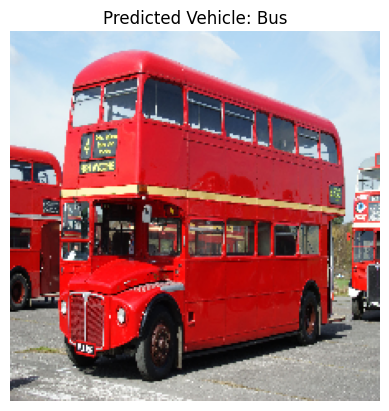

In [13]:
image_path_to_test = './../../training_dataset/dataset (1)/Bus/Image_10.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


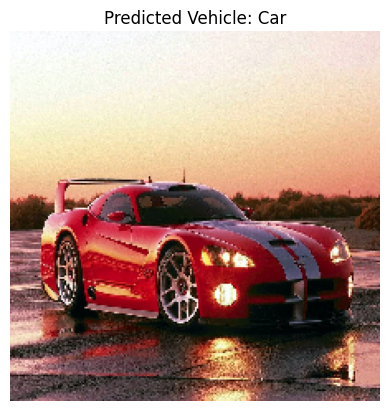

In [14]:
image_path_to_test = './../../training_dataset/dataset (1)/Car/Image_10.jpeg'
predict_and_display(image_path_to_test, model, class_labels)

In [15]:
# Evaluate

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4375 - loss: 7.0503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 6.6556
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5938 - loss: 9.5591
Train Loss:  7.050311088562012
Train Accuracy:  0.4375
--------------------
Validation Loss:  6.655581951141357
Validation Accuracy:  0.375
--------------------
Test Loss:  9.559053421020508
Test Accuracy:  0.59375


In [16]:
# Classification Report

y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Classification Report:
              precision    recall  f1-score   support

         bus       1.00      0.80      0.89        10
         car       0.91      1.00      0.95        10
  motorcycle       0.00      0.00      0.00         5
       truck       0.00      0.00      0.00         7

    accuracy                           0.56        32
   macro avg       0.48      0.45      0.46        32
weighted avg       0.60      0.56      0.58        32

